In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import phik 


from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('./datasets/ad_click_dataset.csv')
df.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


In [4]:
df.duplicated().sum()

2853

In [5]:
df.drop_duplicates(inplace=True)

## EDA

<Axes: xlabel='age', ylabel='Count'>

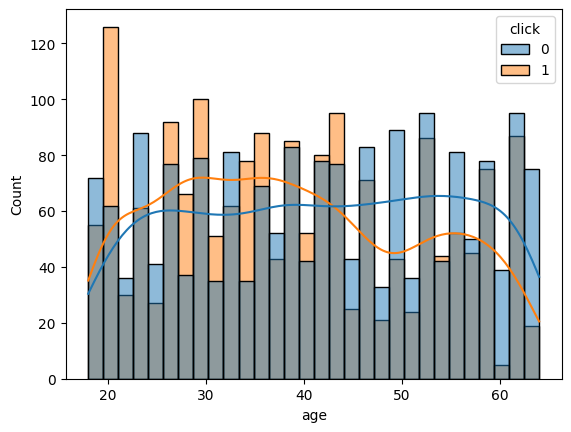

In [6]:
sns.histplot(data=df, x='age', hue='click', bins=30, kde=True)

<Axes: xlabel='ad_position', ylabel='count'>

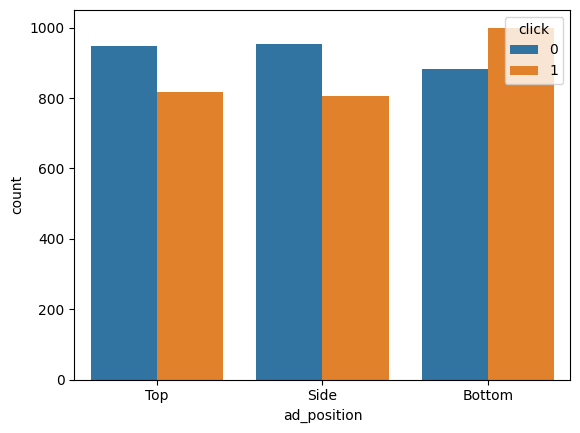

In [7]:
sns.countplot(data=df, x='ad_position', hue='click')

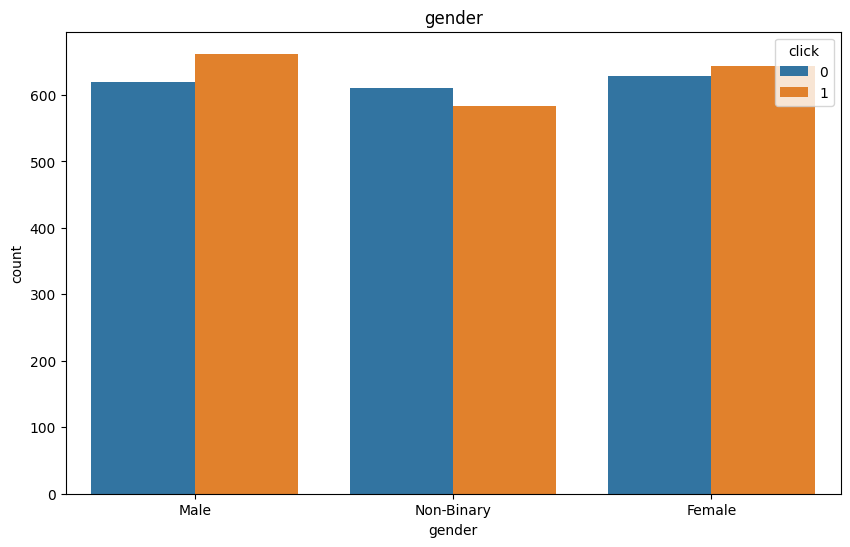

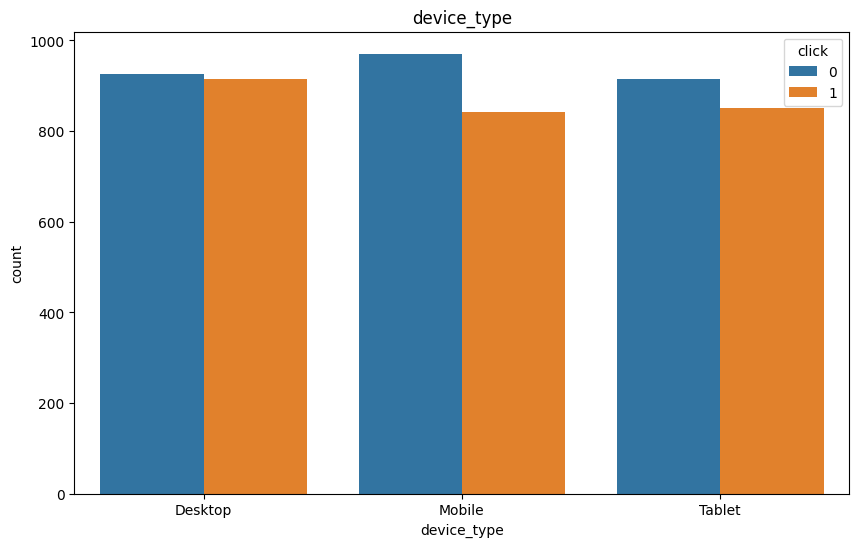

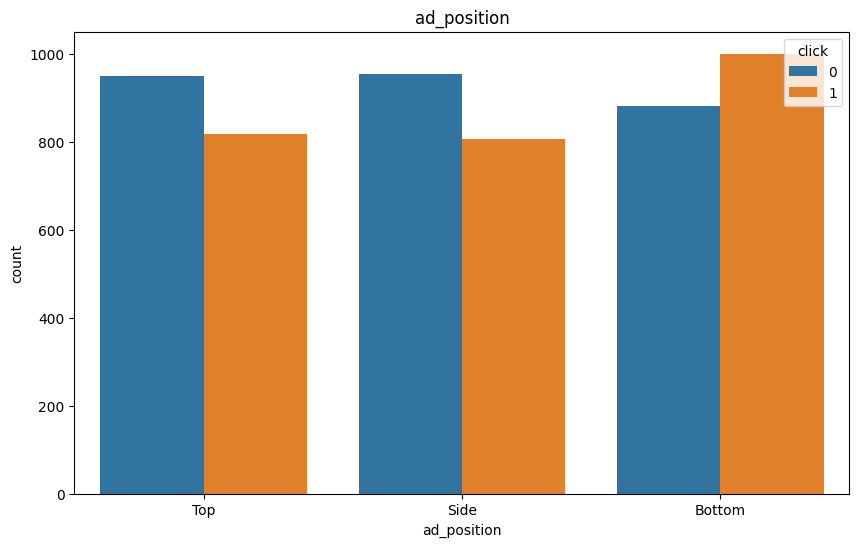

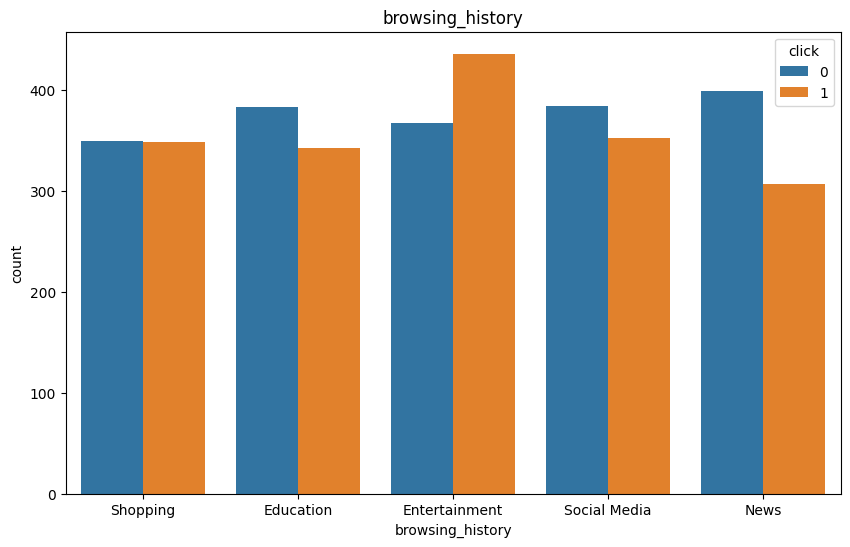

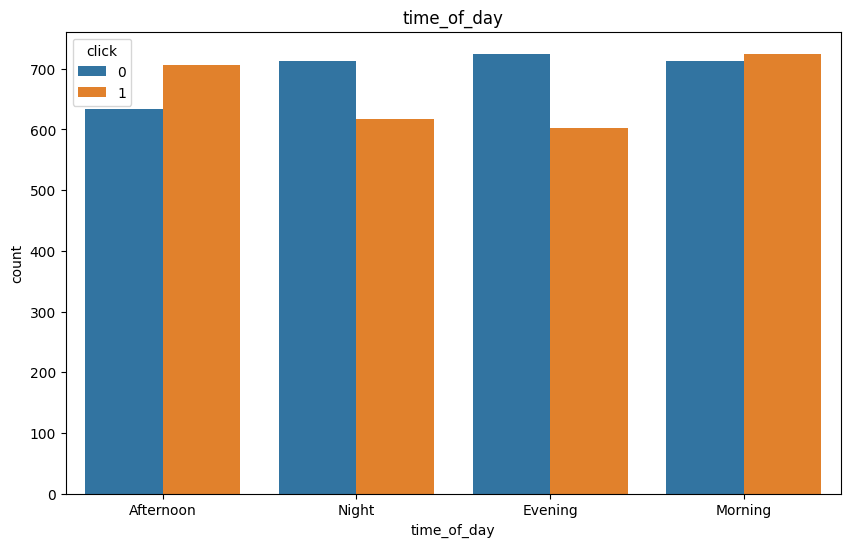

In [8]:
for i in df.select_dtypes('object').columns:
    # Cek apakah kolom bukan 'full_name' dan bukan 'click'
    if i != 'full_name' and i != 'click':
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=i, hue='click')
        plt.title(i)
        plt.show()

#### Correlation with categorical data

In [9]:
phik_ov = df.drop(['id', 'full_name'], axis=1).phik_matrix()
phik_ov

interval columns not set, guessing: ['age', 'click']


,age,gender,device_type,ad_position,browsing_history,time_of_day,click
age,1.000000,0.161269,0.082407,0.131456,0.260083,0.092209,0.167283
gender,0.161269,1.000000,0.113159,0.082392,0.072692,0.038745,0.002085
device_type,0.082407,0.113159,1.000000,0.084955,0.095959,0.033903,0.011050
ad_position,0.131456,0.082392,0.084955,1.000000,0.078897,0.000000,0.039303
browsing_history,0.260083,0.072692,0.095959,0.078897,1.000000,0.038073,0.052428
time_of_day,0.092209,0.038745,0.033903,0.000000,0.038073,1.000000,0.081994
click,0.167283,0.002085,0.011050,0.039303,0.052428,0.081994,1.000000


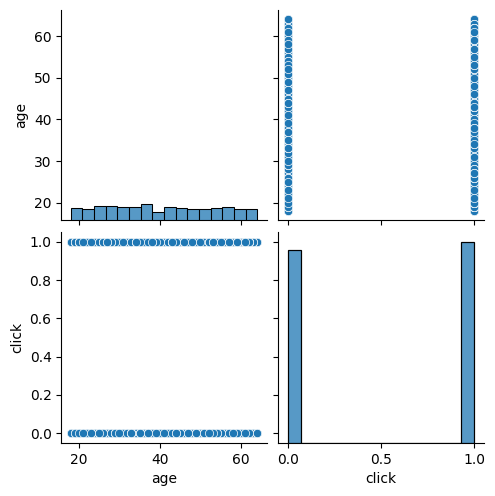

In [10]:
sns.pairplot(df.drop(['id', 'full_name'], axis=1))

## Feature Engineering

In [11]:
X = df.drop(['id', 'full_name','click'], axis=1)
y = df['click']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
y_train.value_counts(normalize=True)

click
1    0.510233
0    0.489767
Name: proportion, dtype: float64

In [14]:
X_train.isna().sum()

age                 2748
gender              2732
device_type         1381
ad_position         1396
browsing_history    2759
time_of_day         1372
dtype: int64

0.0729084423741027


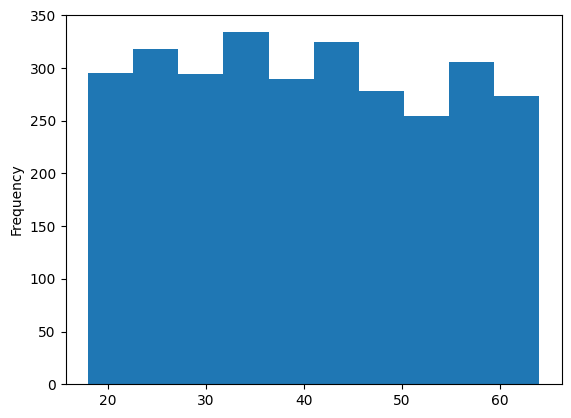

In [15]:
X_train.age.plot(kind='hist')
print(X_train['age'].skew())

In [16]:
imputer_knn = KNNImputer(n_neighbors=5)
imputer_simple = SimpleImputer(strategy='most_frequent')
impute_constant = SimpleImputer(strategy='constant', fill_value='unknown')

In [17]:
scaler = StandardScaler()

In [26]:
nominal = ['gender', 'device_type', 'ad_position', 'browsing_history']
ordinal = ['time_of_day']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
oe = OrdinalEncoder(categories=[['Morning', 'Afternoon', 'Evening', 'Night']])

In [27]:
num_pipe = make_pipeline(imputer_knn, scaler)
nom_pipe = make_pipeline(imputer_simple, ohe)
ord_pipe = make_pipeline(imputer_simple, oe)

preprocess = ColumnTransformer([
  ('numerical', num_pipe, ['age']),
  ('nominal', nom_pipe, nominal),
  ('ordinal', ord_pipe, ordinal)
],
remainder='drop')

preprocess

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age']),
                                ('nominal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'device_type', 'ad_position',
                                  'browsing_history']),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Morning',
                                                                              'Afternoon',
                                                                              'Evening',
                                                                              'Night']]))]),
                                 ['time_of_day'])])

In [20]:
# a = preprocess.fit_transform(X_train)
# pd.DataFrame(a, columns=preprocess.get_feature_names_out())

## Modeling

In [21]:
knn = KNeighborsClassifier()
logreg = LogisticRegression()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()

In [28]:
pipe_knn = Pipeline([('prep', preprocess), ('knn', knn)])
pipe_logreg = Pipeline([('prep', preprocess), ('logreg', logreg)])
pipe_rf = Pipeline([('prep', preprocess), ('rf', rf)])
pipe_ada = Pipeline([('prep', preprocess), ('ada', ada)])

### Cross Validation

In [30]:
cv_knn = cross_val_score(pipe_knn, X_train,y_train, cv=5, scoring='precision')
cv_logreg = cross_val_score(pipe_logreg, X_train, y_train, cv=5, scoring='precision')
cv_rf = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='precision')
cv_ada = cross_val_score(pipe_ada, X_train, y_train, cv=5, scoring='precision')

In [31]:
model = ['KNN',  'Logistic Regression', 'Random Forest', 'Ada Boost']
cv_mean = [cv_knn.mean(), cv_logreg.mean(), cv_rf.mean(), cv_ada.mean()]
cv_std = [cv_knn.std(), cv_logreg.std(), cv_rf.std(), cv_ada.std()]

res = pd.DataFrame({'model' : model, 'cv_mean': cv_mean, 'cv_std': cv_std})
res


,model,cv_mean,cv_std
0,KNN,0.572673,0.014858
1,Logistic Regression,0.563542,0.009958
2,Random Forest,0.588911,0.010190
3,Ada Boost,0.577638,0.005601


### Hyperparameter Tunning

In [44]:
ada_params_grid = {
  # 'ada__estimator' : [LogisticRegression(), 
  #                     RandomForestClassifier(max_depth=1), 
  #                     DecisionTreeClassifier(max_depth=1)],
  'ada__n_estimators': [50, 100, 200],
  'ada__learning_rate': [0.1, 0.5, 1]
  }

In [45]:
ada_grid = GridSearchCV(pipe_ada, param_grid=ada_params_grid,  cv=5, scoring='precision', n_jobs=1, verbose=1)
ada_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age']),
                                                                        ('nominal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]...
                                                                          'browsing_history']),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder(categories=[['Morning',
                                                                                                                      'Afternoon',
                                                                                                                      'Evening',
                                                                                                                      'Night']]))]),
                                                                         ['time_of_day'])])),
                                       ('ada', AdaBoostClassifier())]),
             n_jobs=1,
             param_grid={'ada__learning_rate': [0.1, 0.5, 1],
                         'ada__n_estimators': [50, 100, 200]},
             scoring='precision', verbose=1)

In [46]:
pd.DataFrame(ada_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ada__learning_rate,param_ada__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.506285,0.030624,0.106582,0.014505,0.1,50,"{'ada__learning_rate': 0.1, 'ada__n_estimators...",0.564917,0.563300,0.573333,0.567606,0.570983,0.568028,0.003717,9
1,0.682869,0.074000,0.112683,0.012890,0.1,100,"{'ada__learning_rate': 0.1, 'ada__n_estimators...",0.565217,0.579819,0.581006,0.576562,0.567524,0.574026,0.006459,8
2,0.909716,0.014403,0.131161,0.004579,0.1,200,"{'ada__learning_rate': 0.1, 'ada__n_estimators...",0.569750,0.586207,0.578125,0.579114,0.568038,0.576247,0.006641,5
3,0.509681,0.023181,0.103394,0.006597,0.5,50,"{'ada__learning_rate': 0.5, 'ada__n_estimators...",0.568314,0.581871,0.573314,0.579278,0.571654,0.574886,0.004984,6
4,0.675754,0.029666,0.114048,0.008559,0.5,100,"{'ada__learning_rate': 0.5, 'ada__n_estimators...",0.573723,0.577035,0.573314,0.579968,0.568720,0.574552,0.003787,7
5,0.922491,0.022058,0.128166,0.005550,0.5,200,"{'ada__learning_rate': 0.5, 'ada__n_estimators...",0.571640,0.582242,0.581709,0.582665,0.564184,0.576488,0.007395,4
6,0.495611,0.006499,0.104874,0.005784,1,50,"{'ada__learning_rate': 1, 'ada__n_estimators':...",0.573353,0.581979,0.581930,0.582237,0.568690,0.577638,0.005601,3
7,0.637275,0.017437,0.110866,0.006468,1,100,"{'ada__learning_rate': 1, 'ada__n_estimators':...",0.576751,0.586053,0.576562,0.587849,0.570312,0.579506,0.006531,1
8,0.940666,0.039861,0.132487,0.005751,1,200,"{'ada__learning_rate': 1, 'ada__n_estimators':...",0.577912,0.586411,0.577211,0.581848,0.567442,0.578165,0.006285,2


In [48]:
best_model_ada = ada_grid.best_estimator_
best_model_ada

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('nominal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'device_type',
                                                   'ad_position',
                                                   'browsing_history']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Morning',
                                                                                               'Afternoon',
                                                                                               'Evening',
                                                                                               'Night']]))]),
                                                  ['time_of_day'])])),
                ('ada', AdaBoostClassifier(learning_rate=1, n_estimators=100))])

In [49]:
ada_grid.best_params_

{'ada__learning_rate': 1, 'ada__n_estimators': 100}

In [50]:
ada_grid.best_score_

0.5795056925748303

### Evaluation Model

In [51]:
y_pred_train = best_model_ada.predict(X_train)
y_pred_test = best_model_ada.predict(X_test)

In [53]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.59      0.53      0.56      2800
           1       0.59      0.65      0.62      2917

    accuracy                           0.59      5717
   macro avg       0.59      0.59      0.59      5717
weighted avg       0.59      0.59      0.59      5717

              precision    recall  f1-score   support

           0       0.59      0.50      0.54       700
           1       0.58      0.67      0.62       730

    accuracy                           0.59      1430
   macro avg       0.59      0.58      0.58      1430
weighted avg       0.59      0.59      0.58      1430



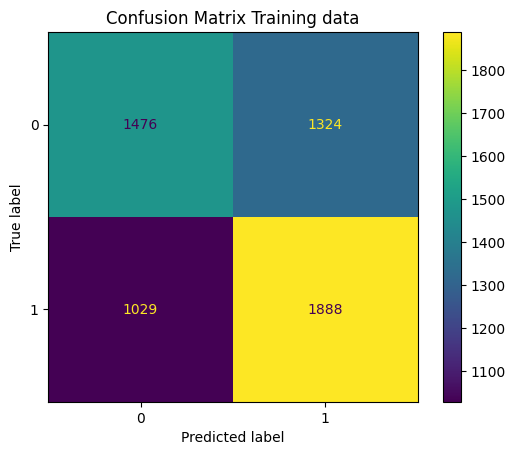

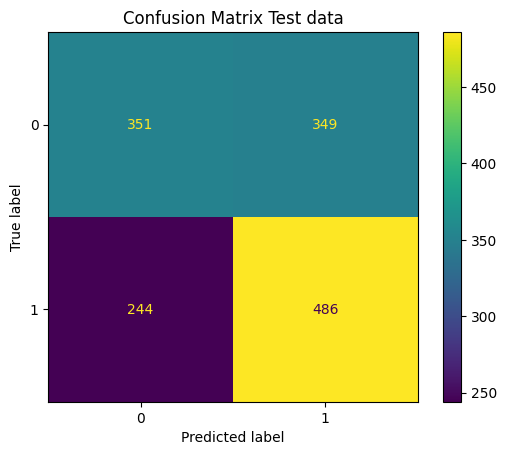

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Tampilkan matriks kebingungan menggunakan ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp.plot()
plt.title('Confusion Matrix Training data')
plt.show()


disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot()
plt.title('Confusion Matrix Test data')
plt.show()

#### Conclusion